# Multiclass Classification with a Neural Network

The following project implements a shallow neural network (1 hidden layer of size 4) to solve the "iris dataset" multiclass classification problem. We use the softmax function as the activation function for the output layer, and categorical cross-entropy loss for the cost function.

In [4]:
import numpy as np
import time
import copy
import sklearn.datasets
import sklearn.model_selection
import sklearn.preprocessing
import matplotlib.pyplot as plt
import sklearn.metrics
import itertools

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Prepare data

In [5]:
dataset = sklearn.datasets.load_iris()
X_train,X_test,Y_train,Y_test = sklearn.model_selection.train_test_split(dataset.data,dataset.target,test_size=0.3,random_state=11)

# Normalize/standardize the features
scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train).T
X_test = scaler.transform(X_test).T

# One-hot encode the target labels
encoder = sklearn.preprocessing.OneHotEncoder(sparse_output=False)
Y_train = encoder.fit_transform(Y_train.reshape(-1, 1)).T
Y_test = encoder.transform(Y_test.reshape(-1, 1)).T

print("Shape of X_train: ",X_train.shape)
print("Shape of Y_train: ",Y_train.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of Y_test: ",Y_test.shape)

Shape of X_train:  (4, 105)
Shape of Y_train:  (3, 105)
Shape of X_test:  (4, 45)
Shape of Y_test:  (3, 45)


## Define model building blocks
- get_nn_dimensions
- initialize_parameters
- propagate_forward
- compute_cost
- propagate_backwards
- update_parameters

In [9]:
def get_nn_dimensions(X:np.ndarray, Y:np.ndarray) -> tuple[int,int,int]:
    
    # Input layer size: One neuron per feature in dataset
    n_input = X.shape[0]
    # Hidden layer size: Four neurons (in this model this is arbitrarily chosen)
    n_hidden = 4
    # Output layer size: One neuron per feature label
    n_output = Y.shape[0]

    return n_input, n_hidden, n_output

In [7]:
def initialize_parameters(n_input:int, n_hidden:int, n_output:int) -> dict:
    """
    Initializes parameters (weights and biases) for a neural network of 1 hidden layer.

    Arguments:
    ---
    - n_input: size of the input layer
    - n_hidden: size of the hidden layer
    - n_output: size of the output layer

    Returns:
    ---
    - parameters: dictionary containing parameters:
        - W1 - weight matrix of shape (n_hidden, n_input)
        - b1 - bias vector of shape (n_hidden, 1)
        - W2 - weight matrix of shape (n_output, n_hidden)
        - b2 - bias vector of shape (n_output, 1)
    """

    parameters = {
        "W1": np.random.randn(n_hidden,n_input) * 0.01,
        "b1": np.zeros((n_hidden,1)),
        "W2": np.random.randn(n_output,n_hidden) * 0.01,
        "b2": np.zeros((n_output,1))
    }
    
    return parameters

In [7]:
def softmax(z):
    exp_z = np.exp(z - np.max(z))
    return exp_z / exp_z.sum(axis=0, keepdims=True)

In [10]:
def propagate_forward(X:np.ndarray, parameters:dict) -> tuple[np.ndarray,dict]:
    """
    Propagates the calculation forward.

    Arguments:
    ---
    - X: input data of size (n_input, m)
    - parameters: dictionary containing parameters

    Returns:
    ---
    - A2: The softmax output of the second activation
    - cache: dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    Z1 = np.dot(W1,X) + b1
    # tanh activation function for hidden layer
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1) + b2
    # Softmax activation function for the output layer
    A2 = softmax(Z2)
    
    assert(A2.shape == (3, X.shape[1]))
    
    cache = {
        "Z1": Z1,
        "A1": A1,
        "Z2": Z2,
        "A2": A2
    }
    
    return A2, cache

In [11]:
def compute_cost(A2:np.ndarray, Y:np.ndarray) -> float:
    """
    Computes the cross-entropy cost.

    Arguments:
    ---
    - A2: The output of the second activation, of shape (1, number of examples)
    - Y: "true" labels vector of shape (1, number of examples)

    Returns:
    ---
    - cost: cross-entropy cost    
    """

    # Number of examples
    m = Y.shape[1] 

    # Calculate cost
    cost = -np.sum(Y * np.log(A2)) / m

    # Ensure cost is the dimension we expect (e.g., turns [[17]] into 17)
    cost = float(np.squeeze(cost))
    
    return cost

In [12]:
def propagate_backwards(parameters:dict, cache:dict, X:np.ndarray, Y:np.ndarray) -> dict:
    """
    Propagates the calculation backwards.

    Arguments:
    ---
    - parameters: dictionary containing parameters
    - cache: dictionary containing "Z1", "A1", "Z2" and "A2"
    - X: input data of shape (n_input, number of examples)
    - Y: "true" labels vector of shape (1, number of examples)

    Returns:
    ---
    - gradients: dictionary containing gradients with respect to different parameters
    """

    m = X.shape[1]

    W1 = parameters['W1']
    W2 = parameters['W2']
    A1 = cache['A1']
    A2 = cache['A2']

    dZ2 = A2 - Y
    dW2 = np.dot(dZ2,A1.T)/m
    db2 = np.sum(dZ2,axis=1,keepdims=True)/m
    dZ1 = np.dot(W2.T,dZ2)*(1 - np.power(A1, 2))
    dW1 = np.dot(dZ1,X.T)/m
    db1 = np.sum(dZ1,axis=1,keepdims=True)/m
    
    gradients = {
        "dW1": dW1,
        "db1": db1,
        "dW2": dW2,
        "db2": db2
    }
    
    return gradients

In [13]:
def update_parameters(parameters:dict, gradients:dict, learning_rate:float) -> dict:
    """
    Updates parameters using the gradient descent.

    Arguments:
    ---
    - parameters: dictionary containing parameters
    - gradients: dictionary containing gradients

    Returns:
    ---
    - parameters: dictionary containing updated_parameters
    """

    W1 = copy.deepcopy(parameters['W1'])
    b1 = parameters['b1']
    W2 = copy.deepcopy(parameters['W2'])
    b2 = parameters['b2']

    dW1 = gradients['dW1']
    db1 = gradients['db1']
    dW2 = gradients['dW2']
    db2 = gradients['db2']
    
    # Update rule for each parameter
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
    
    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }
    
    return parameters

## Create model (using building blocks)

In [14]:
def model(
        X_train:np.ndarray,
        Y_train:np.ndarray,
        X_test:np.ndarray,
        Y_test:np.ndarray,
        num_iterations:int=20000,
        learning_rate:float=0.005
    ) -> tuple[np.ndarray,np.ndarray,list,float]:

    # Start timer
    start_time = time.perf_counter()

    # Get dimensions
    n_input, n_hidden, n_output = get_nn_dimensions(X_train,Y_train)

    # Initialize parameters
    np.random.seed(42)
    parameters = initialize_parameters(n_input, n_hidden, n_output)
    cost = []

    # Optimize parameters (gradient descent)
    for i in range(0, num_iterations):
        A2, cache = propagate_forward(X_train, parameters)
        cost.append(compute_cost(A2,Y_train))
        gradients = propagate_backwards(parameters, cache, X_train, Y_train)
        parameters = update_parameters(parameters, gradients, learning_rate)

    # Predict with optimized parameters
    Y_pred_train, cache = propagate_forward(X_train, parameters)
    Y_pred_test, cache = propagate_forward(X_test, parameters)
    Y_pred_train = (Y_pred_train>0.5).astype(int)
    Y_pred_test = (Y_pred_test>0.5).astype(int)

    # Stop timer and print results
    end_time = time.perf_counter()
    print(f"time elapsed: {end_time - start_time} seconds")
    print(f"train accuracy: {100 - np.mean(np.abs(Y_pred_train - Y_train)) * 100} %")
    print(f"test accuracy: {100 - np.mean(np.abs(Y_pred_test - Y_test)) * 100} %")

    return Y_pred_train, Y_pred_test, cost, learning_rate

## Results

In [13]:
Y_pred_train, Y_pred_test, cost, learning_rate = model(X_train, Y_train, X_test, Y_test)

time elapsed: 1.5616676670033485 seconds
train accuracy: 99.36507936507937 %
test accuracy: 95.55555555555556 %


### Confusion Matrix (test data)

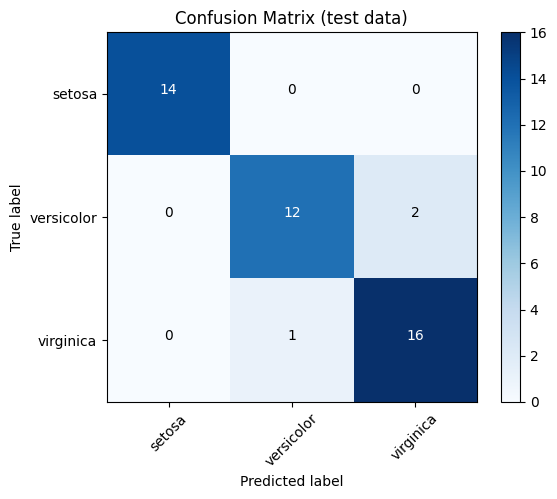

In [14]:
# Convert one-hot encoded arrays to class indices
y_true_indices = np.argmax(Y_test, axis=0)
y_pred_indices = np.argmax(Y_pred_test, axis=0)

# Compute confusion matrix
confusion_matrix = sklearn.metrics.confusion_matrix(y_true_indices, y_pred_indices)

# Plot the confusion matrix
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (test data)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()

labels = dataset.target_names
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
    plt.text(j, i, confusion_matrix[i, j], horizontalalignment="center", color="white" if confusion_matrix[i, j] > confusion_matrix.max() / 2 else "black")

### Learning curve

Text(0.5, 1.0, 'Learning rate =0.005')

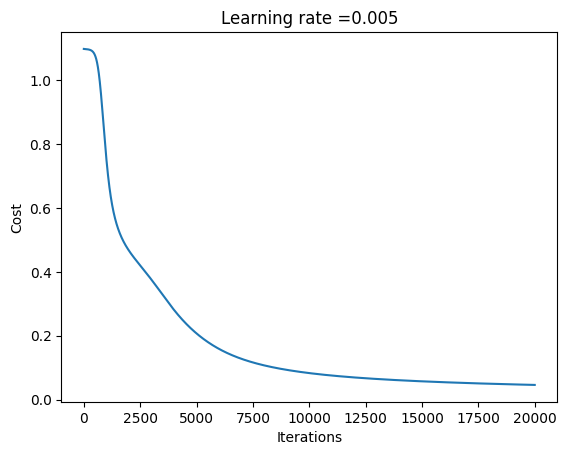

In [15]:
plt.plot(cost)
plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.title("Learning rate =" + str(learning_rate))